In [1]:
import torch
from torch.autograd import Variable
from torch import nn
from torch import optim
from torch.nn import functional as F

import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt


In [2]:
#set to use CPU or GPU automatically based on what is available
def select_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# convert decimal classes Nx2 in (0,9) to binary array Nx10 in (0,1) 
def decimal_to_binary(Array):
    classes_binary_0 = torch.zeros(1000,10) #first image
    classes_binary_1 = torch.zeros(1000,10) #second image
    for i in range(1000):
        classes_binary_0[i,int(Array[i,0].item())] = 1
        classes_binary_1[i,int(Array[i,1].item())] = 1
    return classes_binary_0, classes_binary_1

# convert output of model (Nx20) to decimal class label (Nx2)
def output_to_pred_classes(output):
    _, a = output.data[:,:10].max(1)
    _, b = output.data[:,10:].max(1)
    a = torch.reshape(a,(output.shape[0],1))
    b = torch.reshape(b,(output.shape[0],1))
    return torch.cat((a,b),1)

In [4]:
device = select_device()
print('Device is',device)

Device is cuda


In [5]:
(train_input, train_target, train_classes, test_input, test_target, test_classes) = prologue.generate_pair_sets(1000)



train_input, train_target = train_input.to(device), train_target.to(device)
test_input, test_target = test_input.to(device), test_target.to(device)
train_classes, test_classes = train_classes.to(device), test_classes.to(device)

train_classes_binary_0, train_classes_binary_1 = decimal_to_binary(train_classes)
test_classes_binary_0, test_classes_binary_1 = decimal_to_binary(test_classes)
train_classes_binary = train_classes_binary_0.to(device), train_classes_binary_1.to(device)
test_classes_binary = test_classes_binary_0.to(device), test_classes_binary_1.to(device)

train_input, train_target = Variable(train_input), Variable(train_target)
test_input, test_target = Variable(test_input), Variable(test_target)
train_classes, test_classes = Variable(train_classes), Variable(test_classes)
train_classes_binary_0, test_classes_binary_0 = train_classes_binary_0.to(device), test_classes_binary_0.to(device)
train_classes_binary_1, test_classes_binary_1 = train_classes_binary_1.to(device), test_classes_binary_1.to(device)



/home/zaratras/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/zaratras/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/zaratras/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/zaratras/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
train_input_0 = torch.reshape(train_input[:,0,:,:], (-1, 1, 14, 14))
train_input_1 = torch.reshape(train_input[:,1,:,:], (-1, 1, 14, 14))

test_input_0 = torch.reshape(train_input[:,0,:,:], (-1, 1, 14, 14))
test_input_1 = torch.reshape(train_input[:,1,:,:], (-1, 1, 14, 14))



In [7]:
print('train input size:',train_input.size())
print('train target size:',train_target.size())
print('train classes size:',train_classes.size())
print('test input size:',test_input.size())
print('test target size:',test_target.size())
print('test classes size:',test_classes.size())

train input size: torch.Size([1000, 2, 14, 14])
train target size: torch.Size([1000])
train classes size: torch.Size([1000, 2])
test input size: torch.Size([1000, 2, 14, 14])
test target size: torch.Size([1000])
test classes size: torch.Size([1000, 2])


In [8]:
print('train classes binary size:',train_classes_binary_0.size())
print('train classes binary size:',train_classes_binary_1.size())
print('test classes binary size:',test_classes_binary_0.size())
print('test classes binary size:',test_classes_binary_1.size())

train classes binary size: torch.Size([1000, 10])
train classes binary size: torch.Size([1000, 10])
test classes binary size: torch.Size([1000, 10])
test classes binary size: torch.Size([1000, 10])


In [7]:
class Net(nn.Module):
    def __init__(self,n_hidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 10)
        self.name = "Net1"


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [8]:
def train_model(model, criterion, optimizer, train_input, train_target):

    for e in range(0, 25):
        sum_loss = 0
        nb_errors = 0

        output = model(train_input)
                        
        loss = criterion(output, train_target)

        sum_loss = sum_loss + loss.item()

        model.zero_grad()

        loss.backward()
        optimizer.step()

In [13]:
def compute_nb_errors(model, inputt, target):
    nb_errors = 0

    output = model(inputt)
    _, predicted_classes = output.data.max(1)
    
    for k in range(1000):
        if target.data[k, predicted_classes[k]] <= 0:
            nb_errors = nb_errors + 1

    return nb_errors

In [14]:
eta, mini_batch_size = 1e-1, 100

model, criterion = Net(20), nn.MSELoss()
model, criterion = model.to(device), criterion.to(device)
optimizer = optim.SGD(model.parameters(), lr = eta)

train_model(model.train(), criterion, optimizer, train_input_0, train_classes_binary_0)


RuntimeError: std::exception

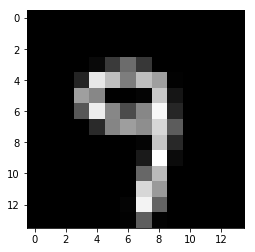

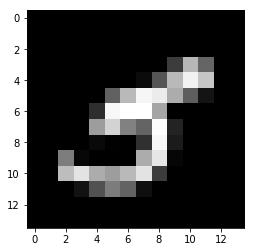

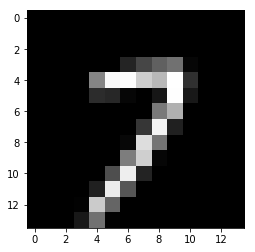

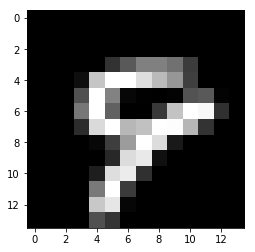

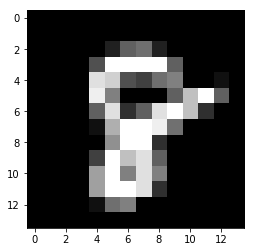

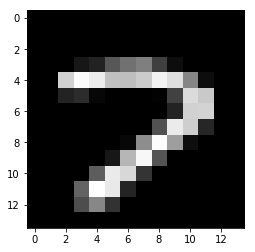

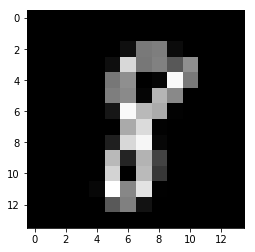

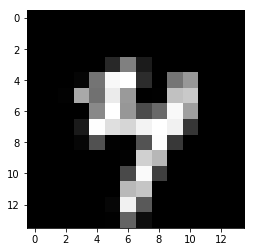

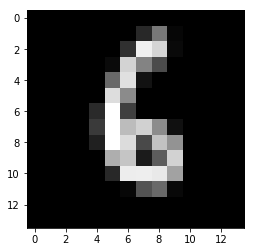

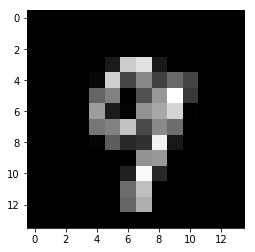

In [25]:
for i in range(10):
    plt.imshow(train_input_0[i,0], cmap='gray', interpolation='none')
    plt.show()
